In [1]:
# MA Cross Backtesting on 1H EURUSD, maps signals from higher timeframe to lower granularity timeframe
# - Spread                  is in the lower 1m timeframe, it will dynamically charge
# - Initial capital         is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe               is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/EURUSD.csv", parse_dates=True, index_col="datetime")
df_

,Open,High,Low,Close,Volume,Spread
datetime,,,,,,
2009-10-20 04:14:00+00:00,1.49814,1.49816,1.49812,1.49812,12,17
2009-10-20 04:15:00+00:00,1.49810,1.49822,1.49806,1.49820,24,16
2009-10-20 04:16:00+00:00,1.49819,1.49820,1.49805,1.49807,22,16
2009-10-20 04:17:00+00:00,1.49805,1.49805,1.49801,1.49803,6,16
2009-10-20 04:18:00+00:00,1.49801,1.49801,1.49789,1.49799,28,16
...,...,...,...,...,...,...
2023-10-16 03:35:00+00:00,1.05200,1.05206,1.05197,1.05206,21,9
2023-10-16 03:36:00+00:00,1.05206,1.05217,1.05206,1.05217,12,9
2023-10-16 03:37:00+00:00,1.05217,1.05217,1.05214,1.05217,6,9


<Axes: xlabel='datetime'>

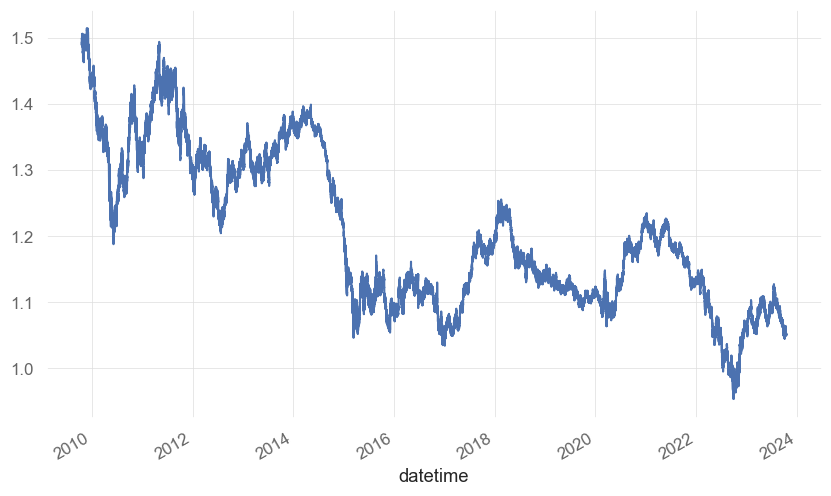

In [4]:
df_['Close'].plot()

In [5]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2009-10-20 04:00:00+00:00,1.49814,1.49822,1.49644,1.49725,1002
2009-10-20 05:00:00+00:00,1.49724,1.49846,1.49653,1.49805,1534
2009-10-20 06:00:00+00:00,1.49804,1.49808,1.49657,1.49781,1879
2009-10-20 07:00:00+00:00,1.49785,1.49870,1.49655,1.49857,3018
2009-10-20 08:00:00+00:00,1.49855,1.49866,1.49560,1.49613,3128
...,...,...,...,...,...
2023-10-15 23:00:00+00:00,1.05213,1.05222,1.05168,1.05216,745
2023-10-16 00:00:00+00:00,1.05218,1.05234,1.05153,1.05173,1564
2023-10-16 01:00:00+00:00,1.05173,1.05251,1.05173,1.05216,1319


In [6]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [7]:
df['Signal'].value_counts()

Signal
 0    85438
-1      976
 1      975
Name: count, dtype: int64

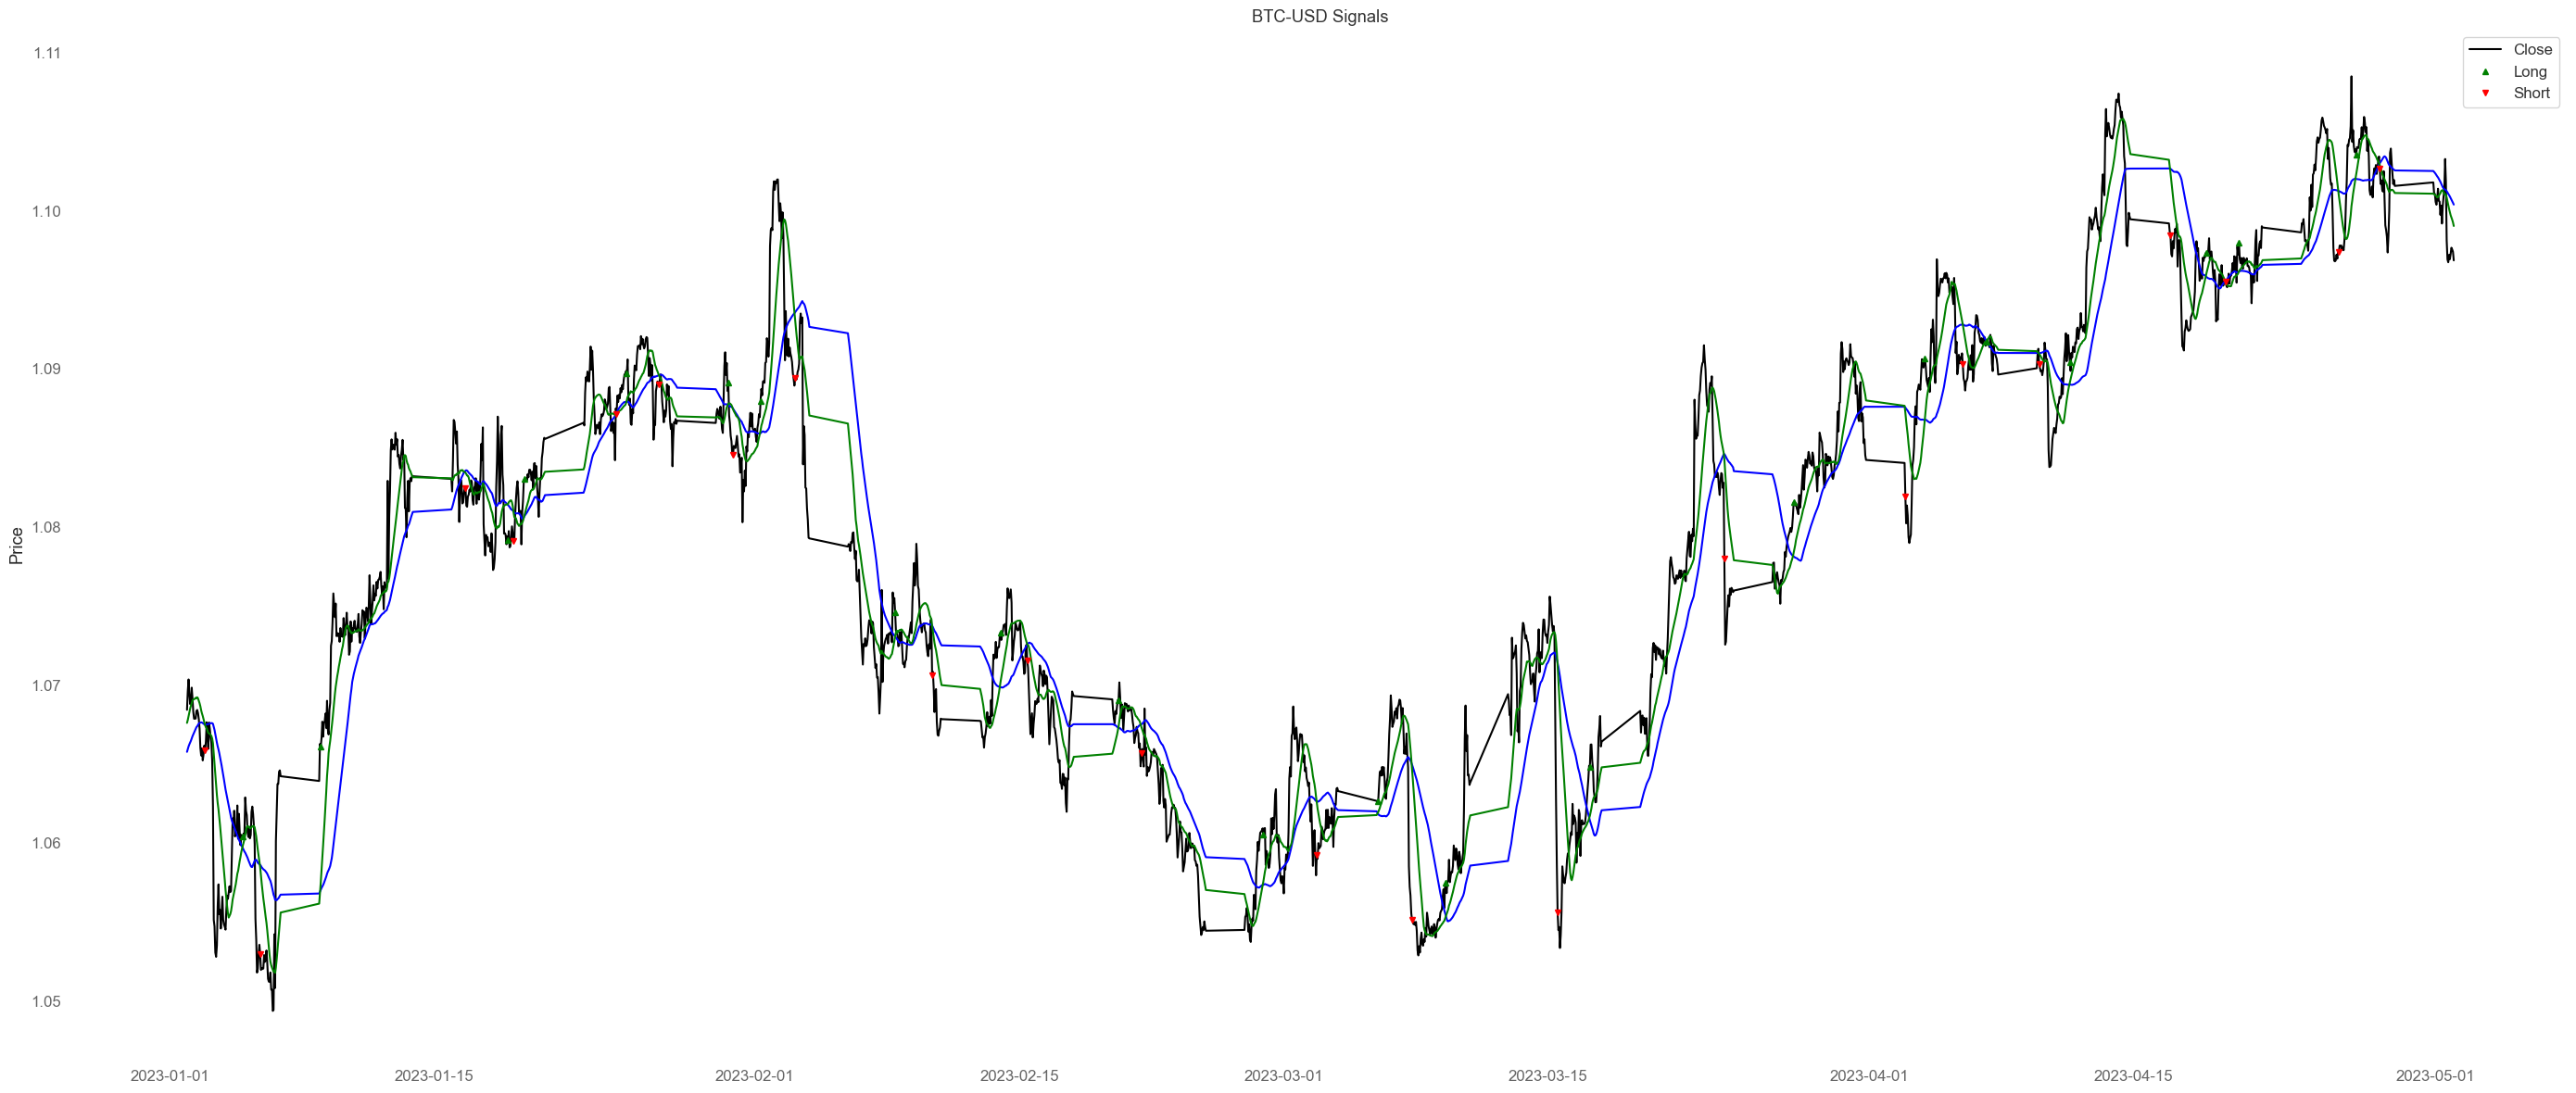

In [8]:
plot_df = df["2023-01-01":"2023-05-01"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=5, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=5, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [9]:
# Saving signals extracted on higher timeframe to lower granularity timeframe

df_eval = df_.copy(deep=True)

df_eval['Signal'] = 0

for idx, row in df[df['Signal']== 1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = 1

for idx, row in df[df['Signal']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = -1

look_ahead_shift = 1
df_eval['Signal' ] = df_eval['Signal' ].shift(hours*60+look_ahead_shift)

df_eval.dropna(inplace=True)

In [10]:
df_eval['Signal'].value_counts()

Signal
 0.0    5177031
-1.0        955
 1.0        952
Name: count, dtype: int64

In [11]:
spread_to_pip_ratio = 1.0 # in JPY based pairs, this ratio would be different
position            = 0
entry_timestamp     = None
entry_price         = 0
exit_timestamp      = None
exit_price          = 0
position_history    = []

for index, row in df_eval.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            spread_by_pips   = row['Spread']
            spread_by_bps    = (spread_by_pips/10000)*spread_to_pip_ratio
            trading_cost_bps = spread_by_bps

            exit_timestamp   = index
            exit_price       = row['Close'] * (1 - trading_cost_bps) if position == 1 else row['Close'] * (1 + trading_cost_bps)
            pct_change       = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))

            #print(f"Exit => cost={trading_cost_bps}, price={row['Close']}, exit_price={exit_price}")

        # Enter new position
        if row['Signal'] == 1:
            spread_by_pips   = row['Spread']
            spread_by_bps    = (spread_by_pips/10000)*spread_to_pip_ratio
            trading_cost_bps = spread_by_bps

            entry_timestamp  = index
            entry_price      = row['Close'] * (1 + trading_cost_bps)

            #print(f"Long => cost={trading_cost_bps}, price={row['Close']}, entry_price={entry_price}")

        elif row['Signal'] == -1:
            spread_by_pips   = row['Spread']
            spread_by_bps    = (spread_by_pips/10000)*spread_to_pip_ratio
            trading_cost_bps = spread_by_bps

            entry_timestamp  = index
            entry_price      = row['Close'] * (1 - trading_cost_bps)

            #print(f"Short => cost={trading_cost_bps}, price={row['Close']}, entry_price={entry_price}")

        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [12]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.0     # 0.0 because broker will charge through the spread instead of commission
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [13]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2009-10-26 15:11:00+00:00,2009-10-26 15:12:00+00:00,1.498659,1.501530,0.191536,0.191536,38.307161,10038.307161,NaN
2009-10-29 22:02:00+00:00,2009-10-29 22:03:00+00:00,1.485834,1.480938,-0.329473,-0.137937,-66.146992,9972.160169,-0.006589
2009-11-02 00:01:00+00:00,2009-11-02 00:02:00+00:00,1.468529,1.473624,0.346931,0.208994,69.193027,10041.353196,0.006939
2009-11-03 04:09:00+00:00,2009-11-03 04:10:00+00:00,1.480382,1.475316,-0.342254,-0.133260,-68.733854,9972.619343,-0.006845
2009-11-03 13:01:00+00:00,2009-11-03 13:02:00+00:00,1.464288,1.467569,0.224100,0.090840,44.697194,10017.316537,0.004482
...,...,...,...,...,...,...,...,...
2023-10-02 11:01:00+00:00,2023-10-02 11:02:00+00:00,1.052872,1.054718,0.175409,6.893358,39.218825,11218.472842,0.003508
2023-10-04 15:01:00+00:00,2023-10-04 15:02:00+00:00,1.050014,1.048336,-0.159856,6.733502,-35.866897,11182.605945,-0.003197
2023-10-09 17:01:00+00:00,2023-10-09 17:02:00+00:00,1.052632,1.054598,0.186818,6.920320,41.782271,11224.388216,0.003736


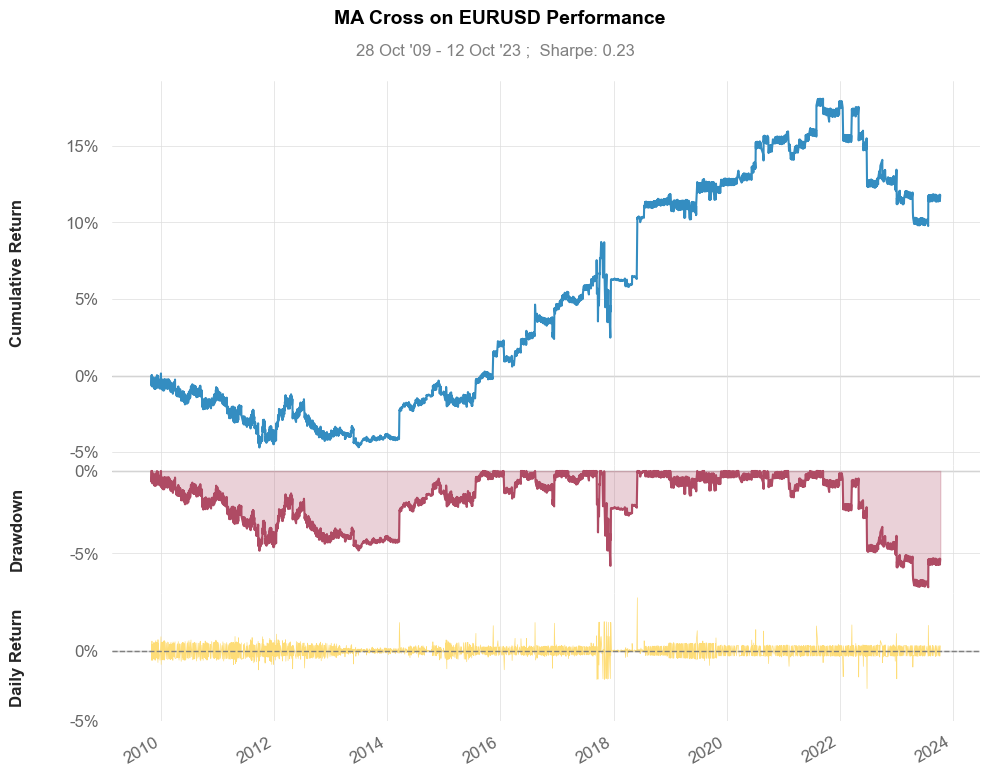

In [14]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on EURUSD Performance', show=True);

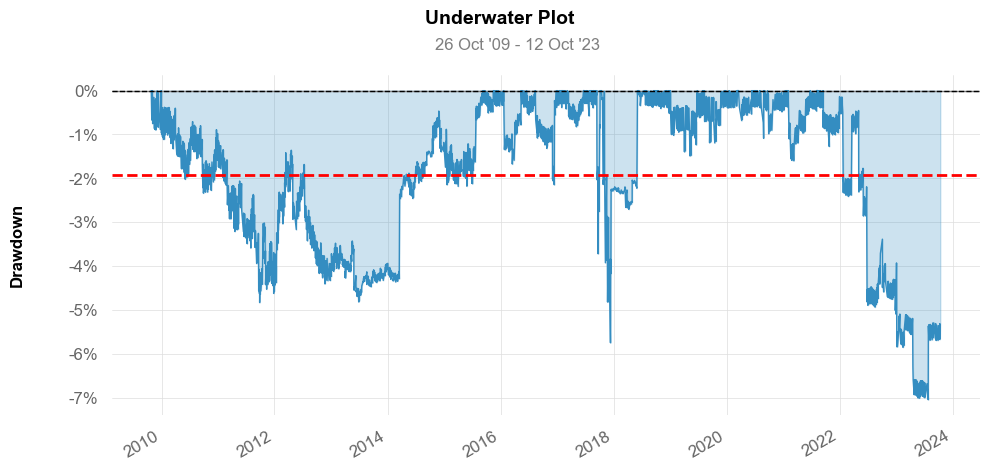

In [15]:
qs.plots.drawdown(position_df['Account Change'])

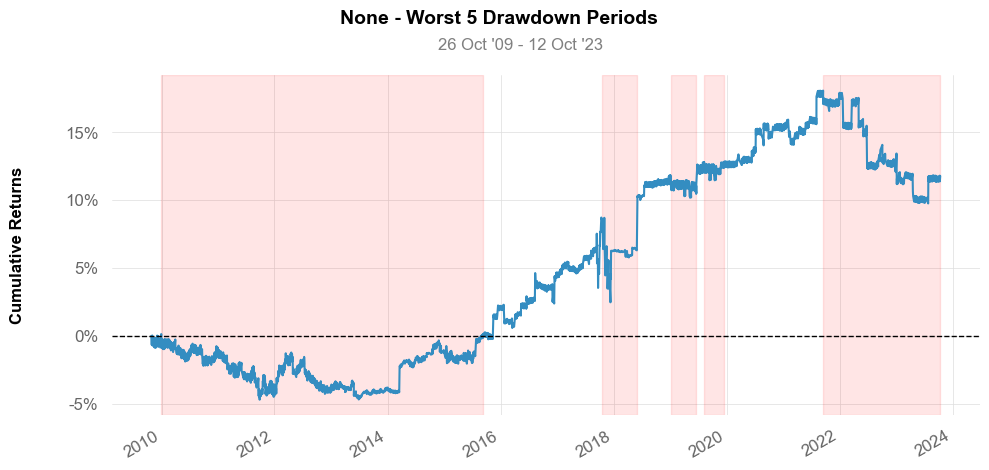

In [16]:
qs.plots.drawdowns_periods(position_df['Account Change'])

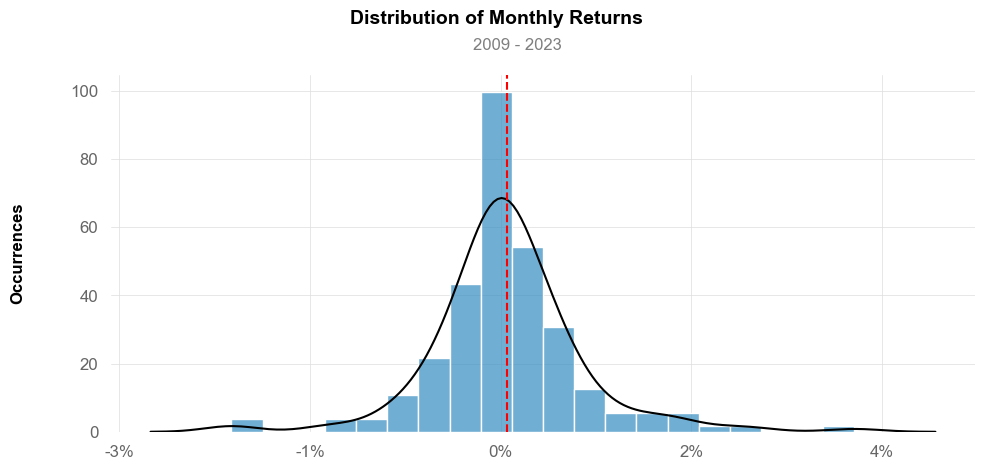

In [17]:
qs.plots.histogram(position_df['Account Change'])

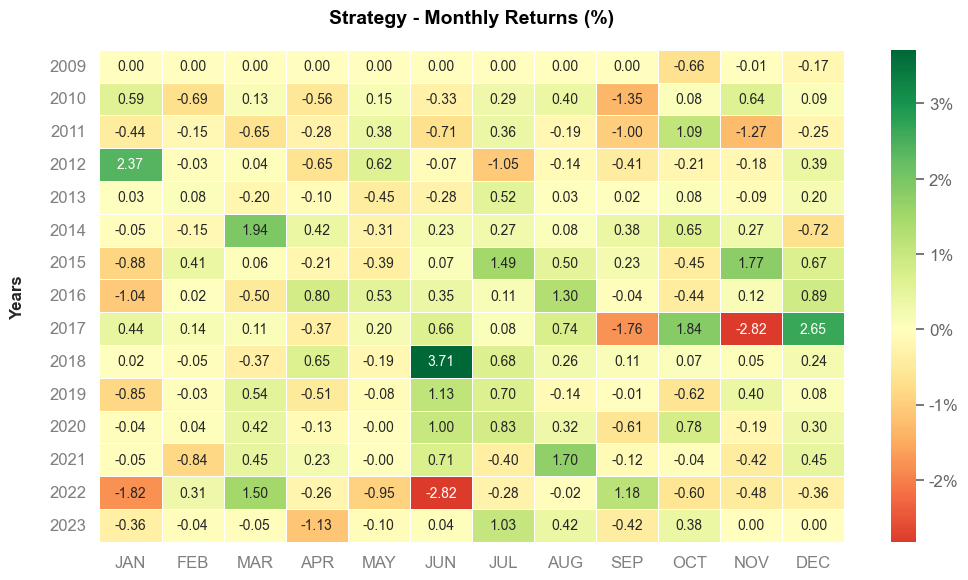

In [18]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [19]:
qs.stats.sharpe(position_df['Account Change'])

0.22805936460065732

In [20]:
qs.stats.sharpe(position_df['Account Change'])

0.22805936460065732

<Axes: xlabel='Entry Time'>

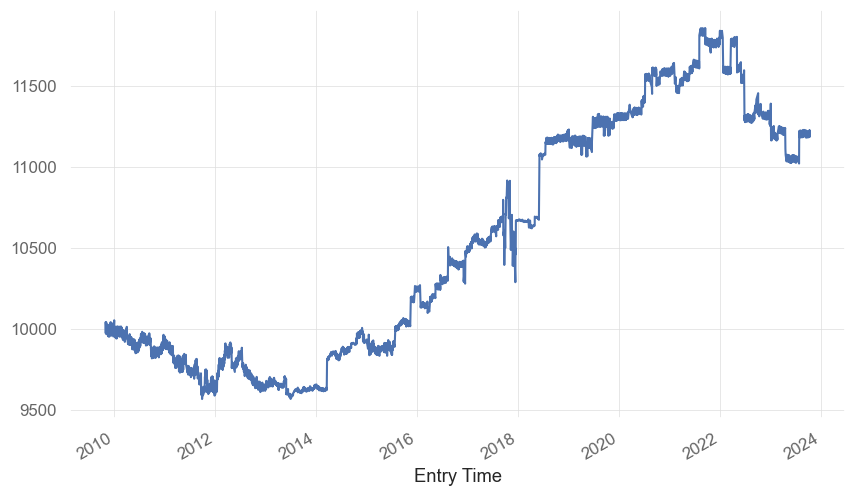

In [21]:
position_df["Account History"].plot()